✅ Using synthetic dataset
Dataset shape: (1000, 5)
     price         sqft  bedrooms  bathrooms        city
0   755025  2216.607253         2          1      Lahore
1  1453929  1545.760089         3          3  Rawalpindi
2   657790  1790.388548         1          1  Rawalpindi
3  1885260  1471.608403         5          5   Islamabad
4  1539259  1414.796209         4          4   Islamabad

📊 Evaluation Metrics
Linear MAE: 123574.97761847705 RMSE: 155470.67093878673
GBR    MAE: 125383.77843570024 RMSE: 157539.60307026157


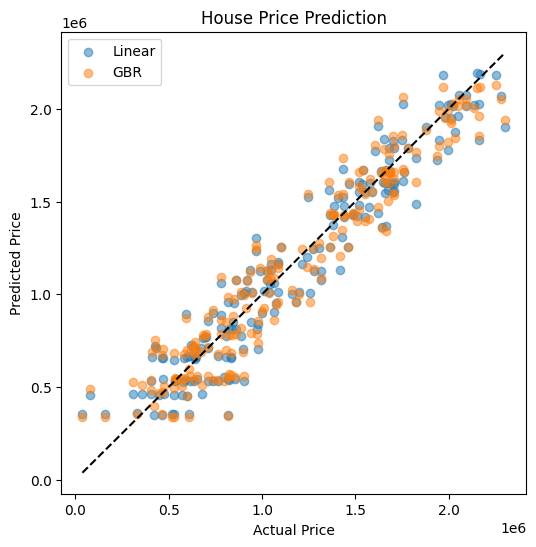

✅ Models saved in artifacts_task6/

💡 Predicted price for custom house: 972309


In [9]:
# Install required packages (if not already installed in Colab)
!pip install --quiet scikit-learn joblib matplotlib pandas

import os, numpy as np, pandas as pd, joblib, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------- Generate synthetic dataset if no CSV uploaded ----------
def make_data(n=1000):
    r=np.random.default_rng(42)
    cities=["Lahore","Karachi","Islamabad","Rawalpindi","Faisalabad"]
    city=r.choice(cities,n)
    sqft=r.normal(1500,500,n).clip(400,6000)
    bed=r.integers(1,6,n)
    bath=np.maximum(1,bed-r.integers(0,2,n))
    base=3000*(sqft/1000)+200000*bed+150000*bath
    factor={c:i for i,c in enumerate(cities)}
    price=base+(np.vectorize(factor.get)(city))*100000+r.normal(0,150000,n)
    return pd.DataFrame(dict(price=price.astype(int),
                             sqft=sqft,bedrooms=bed,bathrooms=bath,city=city))

if os.path.exists("data.csv"):
    df=pd.read_csv("data.csv")
    print("✅ Loaded data.csv")
else:
    df=make_data()
    print("✅ Using synthetic dataset")

print("Dataset shape:", df.shape)
print(df.head())

# ---------- Train/Test Split ----------
X,y=df.drop("price",axis=1),df["price"]
Xtr,Xte,ytr,yte=train_test_split(X,y,test_size=0.2,random_state=42)

# ---------- Preprocessing ----------
prep=ColumnTransformer([
    ("num",StandardScaler(),["sqft","bedrooms","bathrooms"]),
    ("cat",OneHotEncoder(handle_unknown="ignore"),["city"])
])

# ---------- Models ----------
lin=Pipeline([("prep",prep),("model",LinearRegression())])
gbr=Pipeline([("prep",prep),("model",GradientBoostingRegressor(random_state=42))])

lin.fit(Xtr,ytr); gbr.fit(Xtr,ytr)

# ---------- Predictions ----------
pl,pg=lin.predict(Xte),gbr.predict(Xte)

print("\n📊 Evaluation Metrics")
print("Linear MAE:", mean_absolute_error(yte, pl),
      "RMSE:", mean_squared_error(yte, pl) ** 0.5)
print("GBR    MAE:", mean_absolute_error(yte, pg),
      "RMSE:", mean_squared_error(yte, pg) ** 0.5)

# ---------- Plot ----------
plt.figure(figsize=(6,6))
plt.scatter(yte,pl,alpha=.5,label="Linear")
plt.scatter(yte,pg,alpha=.5,label="GBR")
m,M=yte.min(),yte.max()
plt.plot([m,M],[m,M],"k--")
plt.xlabel("Actual Price"); plt.ylabel("Predicted Price")
plt.title("House Price Prediction")
plt.legend()
plt.show()

# ---------- Save models ----------
os.makedirs("artifacts_task6",exist_ok=True)
joblib.dump(lin,"artifacts_task6/linear.joblib")
joblib.dump(gbr,"artifacts_task6/gbr.joblib")
print("✅ Models saved in artifacts_task6/")

# ---------- Custom Prediction ----------
example=pd.DataFrame([dict(sqft=2000,bedrooms=3,bathrooms=2,city="Karachi")])
pred=gbr.predict(example)[0]
print("\n💡 Predicted price for custom house:", int(pred))
